In [1]:
!pip install ccxt pandas numpy matplotlib statsmodels pykalman

In [11]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pykalman import KalmanFilter
import time
import warnings
warnings.filterwarnings('ignore')

In [12]:
def fetch_crypto_data(symbol, timeframe, since, limit=1000):
    
    #Fetching historical OHLCV data using the CCXT library. This returns a DataFrame with Timestamp as index and Close prices
    exchange = ccxt.binanceus()
    # Convert ISO formatted string to exchange timestamp
    since = exchange.parse8601(since)
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    return df[['Timestamp', 'Close']].set_index('Timestamp')

# Fetching daily data for BTC/USDT and ETH/USDT starting from Jan 1, 2017
btc = fetch_crypto_data('BTC/USDT', '1h', '2017-01-01T00:00:00Z')
eth = fetch_crypto_data('LTC/USDT', '1h', '2017-01-01T00:00:00Z')

# Merge the two datasets on the Timestamp index
data = pd.merge(btc, eth, left_index=True, right_index=True, suffixes=('_BTC', '_LTC')).dropna()


In [13]:
def johansen_test(prices):
    
    #Performing Johansen cointegration test on the provided price DataFrame. this will return a boolean indicating whether the series are cointegrated.
    
    # det_order=0 implies no deterministic trend, k_ar_diff=1 sets lag differences.
    result = coint_johansen(prices, det_order=0, k_ar_diff=1)
    # We use the first trace statistic and its 5% critical value
    trace_stat = result.lr1[0]
    crit_value = result.cvt[0, 1]  # 5% significance level critical value
    cointegrated = trace_stat > crit_value
    print("Johansen Test: Trace Statistic = {:.2f}, Critical Value (5%) = {:.2f}".format(trace_stat, crit_value))
    print("Result: {}".format("Cointegrated" if cointegrated else "Not Cointegrated"))
    return cointegrated

# Running cointegration test on BTC and ETH closing prices
prices = data[['Close_BTC', 'Close_LTC']]
cointegrated = johansen_test(prices)

Johansen Test: Trace Statistic = 30.84, Critical Value (5%) = 15.49
Result: Cointegrated


In [14]:

def kalman_filter(y, x):
    
    #Using Kalman filter to estimate  time-varying linear relationship between BTC and ETH, which returns arrays for the dynamic hedge ratio and intercept.
    
    
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance for [hedge_ratio, intercept]
    
    # Observation matrix: each observation is [x, 1]
    obs_mat = np.vstack([x, np.ones(len(x))]).T[:, np.newaxis]
    
    # Initialize Kalman Filter
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[0, 0],
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    # Apply the filter to estimate state (hedge ratio and intercept)
    state_means, _ = kf.filter(y.values)
    hedge_ratio = state_means[:, 0]
    intercept = state_means[:, 1]
    
    return hedge_ratio, intercept

# Estimate dynamic hedge ratio (and intercept) using ETH as y and BTC as x
hedge_ratio, intercept = kalman_filter(data['Close_LTC'], data['Close_BTC'])
# Compute the dynamic spread: the deviation of ETH price from its estimated linear relation with BTC
data['Spread'] = data['Close_LTC'] - (hedge_ratio * data['Close_BTC'] + intercept)


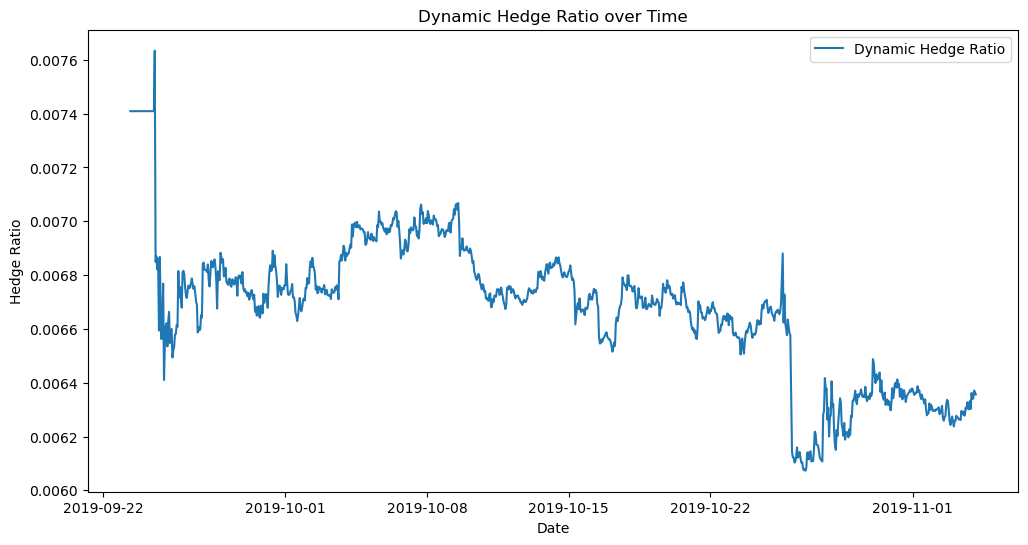

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, hedge_ratio, label='Dynamic Hedge Ratio')
plt.title('Dynamic Hedge Ratio over Time')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.show()


In [17]:
def calculate_zscore(spread, window=20):
    
    #Calculating the rolling Z-score for the spread. Z-score = (spread - rolling mean) / rolling standard deviation.
    
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    zscore = (spread - rolling_mean) / rolling_std
    return zscore

# Calculate the Z-score for the spread
data['Zscore'] = calculate_zscore(data['Spread'])


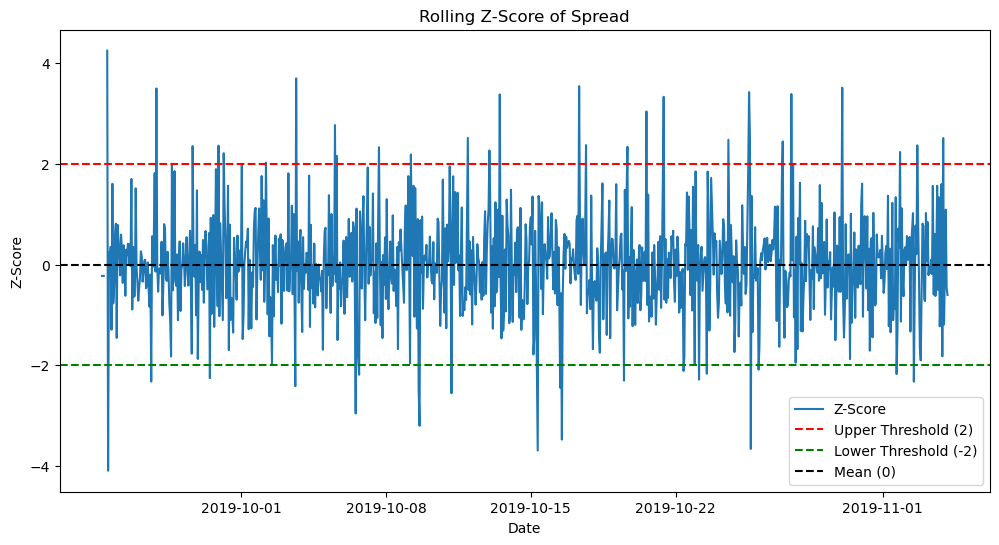

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Zscore'], label='Z-Score')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
plt.axhline(0, color='black', linestyle='--', label='Mean (0)')
plt.title('Rolling Z-Score of Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()


In [19]:

def backtest_trading(data, z_entry=2.0, z_exit=0.0):
    """
    Backtesting a simple pairs trading strategy based on Z-score signals.
    Entry Rules:
      - If Z-score > z_entry, then short ETH and long BTC.
      - If Z-score < -z_entry, then long ETH and short BTC.
    Exit Rule:
      - Close position when Z-score reverts to z_exit.
    Returns a list of individual trade PnLs and prints trade details.
    """
    position = 0  # +1: long ETH / short BTC; -1: short ETH / long BTC
    entry_idx = None
    trade_returns = []
    
    for i in range(len(data)):
        z = data['Zscore'].iloc[i]
        current_date = data.index[i]
        price_eth = data['Close_LTC'].iloc[i]
        price_btc = data['Close_BTC'].iloc[i]
        # For simplicity, we assume the hedge ratio is approximated by its current estimated value
        current_hr = hedge_ratio[i]
        
        # ENTRY CONDITIONS: only if we are flat (no open position)
        if position == 0:
            if z > z_entry:
                # Signal: Spread too high -> ETH is expensive relative to BTC.
                # Action: Short ETH, Long BTC.
                position = -1
                entry_idx = i
                entry_price_eth = price_eth
                entry_price_btc = price_btc
                print(f"{current_date}: Enter SHORT LTC, LONG BTC (Z = {z:.2f})")
            elif z < -z_entry:
                # Signal: Spread too low -> ETH is cheap relative to BTC.
                # Action: Long ETH, Short BTC.
                position = 1
                entry_idx = i
                entry_price_eth = price_eth
                entry_price_btc = price_btc
                print(f"{current_date}: Enter LONG LTC, SHORT BTC (Z = {z:.2f})")
        
        # EXIT CONDITION: if we are in a position and Z-score reverts to near zero
        elif position != 0:
            if (position == 1 and z >= z_exit) or (position == -1 and z <= z_exit):
                exit_price_eth = price_eth
                exit_price_btc = price_btc
                
                # Compute profit & loss (PnL) using a simple spread difference approach.
                # For a LONG ETH / SHORT BTC position, profit is (exit_eth - entry_eth) - current_hr*(exit_btc - entry_btc)
                # For a SHORT ETH / LONG BTC position, profit is the reverse.
                if position == 1:
                    pnl = (exit_price_eth - entry_price_eth) - current_hr * (exit_price_btc - entry_price_btc)
                    trade_type = "LONG LTC, SHORT BTC"
                else:  # position == -1
                    pnl = (entry_price_eth - exit_price_eth) - current_hr * (entry_price_btc - exit_price_btc)
                    trade_type = "SHORT LTC, LONG BTC"
                
                trade_returns.append(pnl)
                print(f"{current_date}: Exit position ({trade_type}) with PnL: {pnl:.2f}")
                position = 0  # reset position
                entry_idx = None

    total_profit = sum(trade_returns)
    print(f"\nTotal Profit from Backtesting: {total_profit:.2f}")
    return trade_returns

# Run backtesting simulation on our data
trade_returns = backtest_trading(data)


2019-09-24 13:00:00: Enter SHORT LTC, LONG BTC (Z = 4.25)
2019-09-24 14:00:00: Exit position (SHORT LTC, LONG BTC) with PnL: 7.57
2019-09-26 16:00:00: Enter LONG LTC, SHORT BTC (Z = -2.32)
2019-09-26 17:00:00: Exit position (LONG LTC, SHORT BTC) with PnL: 0.16
2019-09-26 22:00:00: Enter SHORT LTC, LONG BTC (Z = 3.50)
2019-09-26 23:00:00: Exit position (SHORT LTC, LONG BTC) with PnL: -0.04
2019-09-28 16:00:00: Enter SHORT LTC, LONG BTC (Z = 2.35)
2019-09-28 18:00:00: Exit position (SHORT LTC, LONG BTC) with PnL: 0.04
2019-09-29 12:00:00: Enter LONG LTC, SHORT BTC (Z = -2.25)
2019-09-29 13:00:00: Exit position (LONG LTC, SHORT BTC) with PnL: 0.15
2019-09-29 22:00:00: Enter SHORT LTC, LONG BTC (Z = 2.36)
2019-09-29 23:00:00: Exit position (SHORT LTC, LONG BTC) with PnL: 0.27
2019-09-30 04:00:00: Enter SHORT LTC, LONG BTC (Z = 2.21)
2019-09-30 07:00:00: Exit position (SHORT LTC, LONG BTC) with PnL: -0.42
2019-10-02 05:00:00: Enter SHORT LTC, LONG BTC (Z = 2.02)
2019-10-02 07:00:00: Exit po

In [20]:
def fetch_crypto_data(symbol, timeframe, since, limit=1000):
    
    #Fetching historical OHLCV data using the CCXT library. This returns a DataFrame with Timestamp as index and Close prices
    exchange = ccxt.binanceus()
    # Convert ISO formatted string to exchange timestamp
    since = exchange.parse8601(since)
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    return df[['Timestamp', 'Close']].set_index('Timestamp')

# Fetching daily data for BTC/USDT and ETH/USDT starting from Jan 1, 2017
btc = fetch_crypto_data('ETH/USDT', '1h', '2017-01-01T00:00:00Z')
eth = fetch_crypto_data('LTC/USDT', '1h', '2017-01-01T00:00:00Z')

# Merge the two datasets on the Timestamp index
data = pd.merge(btc, eth, left_index=True, right_index=True, suffixes=('_ETH', '_LTC')).dropna()


In [21]:
def johansen_test(prices):
    
    #Performing Johansen cointegration test on the provided price DataFrame. this will return a boolean indicating whether the series are cointegrated.
    
    # det_order=0 implies no deterministic trend, k_ar_diff=1 sets lag differences.
    result = coint_johansen(prices, det_order=0, k_ar_diff=1)
    # We use the first trace statistic and its 5% critical value
    trace_stat = result.lr1[0]
    crit_value = result.cvt[0, 1]  # 5% significance level critical value
    cointegrated = trace_stat > crit_value
    print("Johansen Test: Trace Statistic = {:.2f}, Critical Value (5%) = {:.2f}".format(trace_stat, crit_value))
    print("Result: {}".format("Cointegrated" if cointegrated else "Not Cointegrated"))
    return cointegrated

# Running cointegration test on BTC and ETH closing prices
prices = data[['Close_ETH', 'Close_LTC']]
cointegrated = johansen_test(prices)

Johansen Test: Trace Statistic = 34.47, Critical Value (5%) = 15.49
Result: Cointegrated


In [22]:

def kalman_filter(y, x):
    
    #Using Kalman filter to estimate  time-varying linear relationship between BTC and ETH, which returns arrays for the dynamic hedge ratio and intercept.
    
    
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance for [hedge_ratio, intercept]
    
    # Observation matrix: each observation is [x, 1]
    obs_mat = np.vstack([x, np.ones(len(x))]).T[:, np.newaxis]
    
    # Initialize Kalman Filter
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[0, 0],
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    # Apply the filter to estimate state (hedge ratio and intercept)
    state_means, _ = kf.filter(y.values)
    hedge_ratio = state_means[:, 0]
    intercept = state_means[:, 1]
    
    return hedge_ratio, intercept

# Estimate dynamic hedge ratio (and intercept) using ETH as y and BTC as x
hedge_ratio, intercept = kalman_filter(data['Close_LTC'], data['Close_ETH'])
# Compute the dynamic spread: the deviation of ETH price from its estimated linear relation with BTC
data['Spread'] = data['Close_LTC'] - (hedge_ratio * data['Close_ETH'] + intercept)


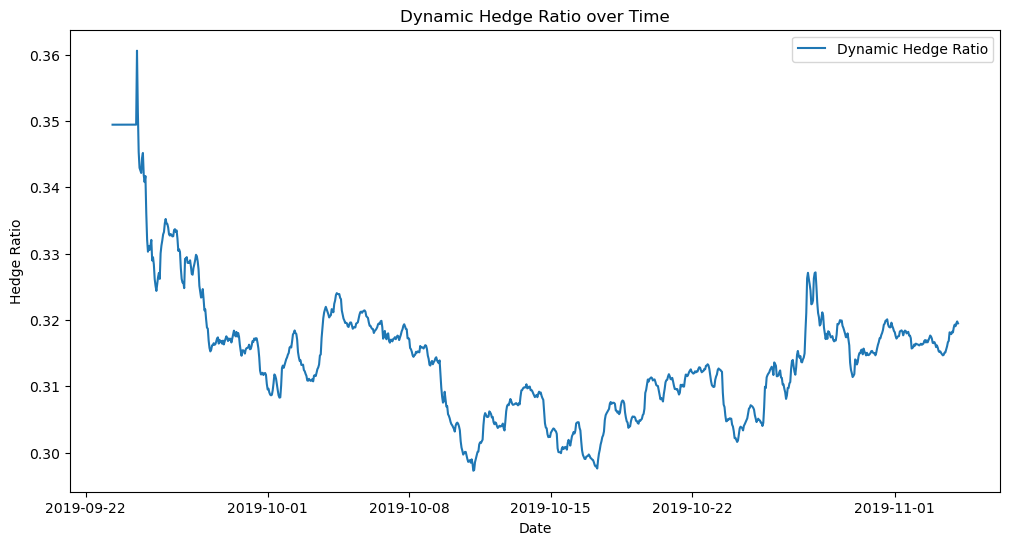

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, hedge_ratio, label='Dynamic Hedge Ratio')
plt.title('Dynamic Hedge Ratio over Time')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.show()


In [26]:
def calculate_zscore(spread, window=20):
    
    #Calculating the rolling Z-score for the spread. Z-score = (spread - rolling mean) / rolling standard deviation.
    
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    zscore = (spread - rolling_mean) / rolling_std
    return zscore

# Calculate the Z-score for the spread
data['Zscore'] = calculate_zscore(data['Spread'])


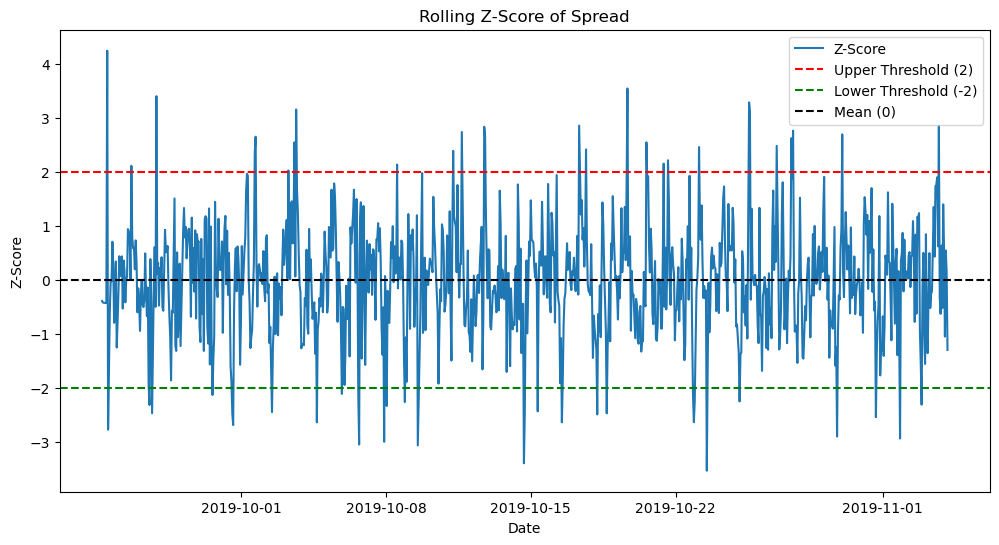

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Zscore'], label='Z-Score')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
plt.axhline(0, color='black', linestyle='--', label='Mean (0)')
plt.title('Rolling Z-Score of Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()


In [28]:

def backtest_trading(data, z_entry=2.0, z_exit=0.0):
    """
    Backtesting a simple pairs trading strategy based on Z-score signals.
    Entry Rules:
      - If Z-score > z_entry, then short ETH and long BTC.
      - If Z-score < -z_entry, then long ETH and short BTC.
    Exit Rule:
      - Close position when Z-score reverts to z_exit.
    Returns a list of individual trade PnLs and prints trade details.
    """
    position = 0  # +1: long ETH / short BTC; -1: short ETH / long BTC
    entry_idx = None
    trade_returns = []
    
    for i in range(len(data)):
        z = data['Zscore'].iloc[i]
        current_date = data.index[i]
        price_eth = data['Close_LTC'].iloc[i]
        price_btc = data['Close_ETH'].iloc[i]
        # For simplicity, we assume the hedge ratio is approximated by its current estimated value
        current_hr = hedge_ratio[i]
        
        # ENTRY CONDITIONS: only if we are flat (no open position)
        if position == 0:
            if z > z_entry:
                # Signal: Spread too high -> ETH is expensive relative to BTC.
                # Action: Short ETH, Long BTC.
                position = -1
                entry_idx = i
                entry_price_eth = price_eth
                entry_price_btc = price_btc
                print(f"{current_date}: Enter SHORT LTC, LONG ETH (Z = {z:.2f})")
            elif z < -z_entry:
                # Signal: Spread too low -> ETH is cheap relative to BTC.
                # Action: Long ETH, Short BTC.
                position = 1
                entry_idx = i
                entry_price_eth = price_eth
                entry_price_btc = price_btc
                print(f"{current_date}: Enter LONG LTC, SHORT ETH (Z = {z:.2f})")
        
        # EXIT CONDITION: if we are in a position and Z-score reverts to near zero
        elif position != 0:
            if (position == 1 and z >= z_exit) or (position == -1 and z <= z_exit):
                exit_price_eth = price_eth
                exit_price_btc = price_btc
                
                # Compute profit & loss (PnL) using a simple spread difference approach.
                # For a LONG ETH / SHORT BTC position, profit is (exit_eth - entry_eth) - current_hr*(exit_btc - entry_btc)
                # For a SHORT ETH / LONG BTC position, profit is the reverse.
                if position == 1:
                    pnl = (exit_price_eth - entry_price_eth) - current_hr * (exit_price_btc - entry_price_btc)
                    trade_type = "LONG LTC, SHORT ETH"
                else:  # position == -1
                    pnl = (entry_price_eth - exit_price_eth) - current_hr * (entry_price_btc - exit_price_btc)
                    trade_type = "SHORT LTC, LONG ETH"
                
                trade_returns.append(pnl)
                print(f"{current_date}: Exit position ({trade_type}) with PnL: {pnl:.2f}")
                position = 0  # reset position
                entry_idx = None

    total_profit = sum(trade_returns)
    print(f"\nTotal Profit from Backtesting: {total_profit:.2f}")
    return trade_returns

# Run backtesting simulation on our data
trade_returns = backtest_trading(data)


2019-09-24 13:00:00: Enter SHORT LTC, LONG ETH (Z = 4.25)
2019-09-24 14:00:00: Exit position (SHORT LTC, LONG ETH) with PnL: 6.71
2019-09-25 17:00:00: Enter SHORT LTC, LONG ETH (Z = 2.12)
2019-09-26 00:00:00: Exit position (SHORT LTC, LONG ETH) with PnL: 0.33
2019-09-26 14:00:00: Enter LONG LTC, SHORT ETH (Z = -2.31)
2019-09-26 15:00:00: Exit position (LONG LTC, SHORT ETH) with PnL: 0.55
2019-09-26 17:00:00: Enter LONG LTC, SHORT ETH (Z = -2.47)
2019-09-26 20:00:00: Exit position (LONG LTC, SHORT ETH) with PnL: 0.28
2019-09-26 22:00:00: Enter SHORT LTC, LONG ETH (Z = 3.41)
2019-09-27 01:00:00: Exit position (SHORT LTC, LONG ETH) with PnL: 1.40
2019-09-29 15:00:00: Enter LONG LTC, SHORT ETH (Z = -2.13)
2019-09-29 18:00:00: Exit position (LONG LTC, SHORT ETH) with PnL: 0.36
2019-09-30 14:00:00: Enter LONG LTC, SHORT ETH (Z = -2.47)
2019-09-30 17:00:00: Exit position (LONG LTC, SHORT ETH) with PnL: -0.12
2019-10-01 16:00:00: Enter SHORT LTC, LONG ETH (Z = 2.35)
2019-10-01 19:00:00: Exit p

In [29]:
def fetch_crypto_data(symbol, timeframe, since, limit=1000):
    
    #Fetching historical OHLCV data using the CCXT library. This returns a DataFrame with Timestamp as index and Close prices
    exchange = ccxt.binanceus()
    # Convert ISO formatted string to exchange timestamp
    since = exchange.parse8601(since)
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    return df[['Timestamp', 'Close']].set_index('Timestamp')

# Fetching daily data for BTC/USDT and ETH/USDT starting from Jan 1, 2017
btc = fetch_crypto_data('BTC/USDT', '1h', '2017-01-01T00:00:00Z')
eth = fetch_crypto_data('ETH/USDT', '1h', '2017-01-01T00:00:00Z')

# Merge the two datasets on the Timestamp index
data = pd.merge(btc, eth, left_index=True, right_index=True, suffixes=('_BTC', '_ETH')).dropna()


In [30]:
def johansen_test(prices):
    
    #Performing Johansen cointegration test on the provided price DataFrame. this will return a boolean indicating whether the series are cointegrated.
    
    # det_order=0 implies no deterministic trend, k_ar_diff=1 sets lag differences.
    result = coint_johansen(prices, det_order=0, k_ar_diff=1)
    # We use the first trace statistic and its 5% critical value
    trace_stat = result.lr1[0]
    crit_value = result.cvt[0, 1]  # 5% significance level critical value
    cointegrated = trace_stat > crit_value
    print("Johansen Test: Trace Statistic = {:.2f}, Critical Value (5%) = {:.2f}".format(trace_stat, crit_value))
    print("Result: {}".format("Cointegrated" if cointegrated else "Not Cointegrated"))
    return cointegrated

# Running cointegration test on BTC and ETH closing prices
prices = data[['Close_BTC', 'Close_ETH']]
cointegrated = johansen_test(prices)

Johansen Test: Trace Statistic = 23.17, Critical Value (5%) = 15.49
Result: Cointegrated


In [31]:

def kalman_filter(y, x):
    
    #Using Kalman filter to estimate  time-varying linear relationship between BTC and ETH, which returns arrays for the dynamic hedge ratio and intercept.
    
    
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)  # Transition covariance for [hedge_ratio, intercept]
    
    # Observation matrix: each observation is [x, 1]
    obs_mat = np.vstack([x, np.ones(len(x))]).T[:, np.newaxis]
    
    # Initialize Kalman Filter
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[0, 0],
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    # Apply the filter to estimate state (hedge ratio and intercept)
    state_means, _ = kf.filter(y.values)
    hedge_ratio = state_means[:, 0]
    intercept = state_means[:, 1]
    
    return hedge_ratio, intercept

# Estimate dynamic hedge ratio (and intercept) using ETH as y and BTC as x
hedge_ratio, intercept = kalman_filter(data['Close_ETH'], data['Close_BTC'])
# Compute the dynamic spread: the deviation of ETH price from its estimated linear relation with BTC
data['Spread'] = data['Close_ETH'] - (hedge_ratio * data['Close_BTC'] + intercept)


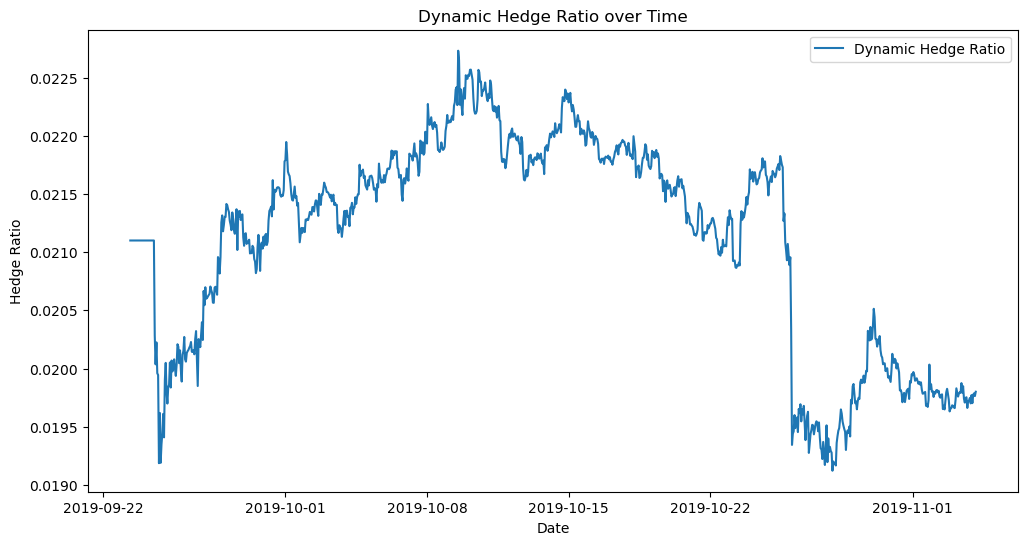

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, hedge_ratio, label='Dynamic Hedge Ratio')
plt.title('Dynamic Hedge Ratio over Time')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.show()


In [33]:
def calculate_zscore(spread, window=20):
    
    #Calculating the rolling Z-score for the spread. Z-score = (spread - rolling mean) / rolling standard deviation.
    
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    zscore = (spread - rolling_mean) / rolling_std
    return zscore

# Calculate the Z-score for the spread
data['Zscore'] = calculate_zscore(data['Spread'])


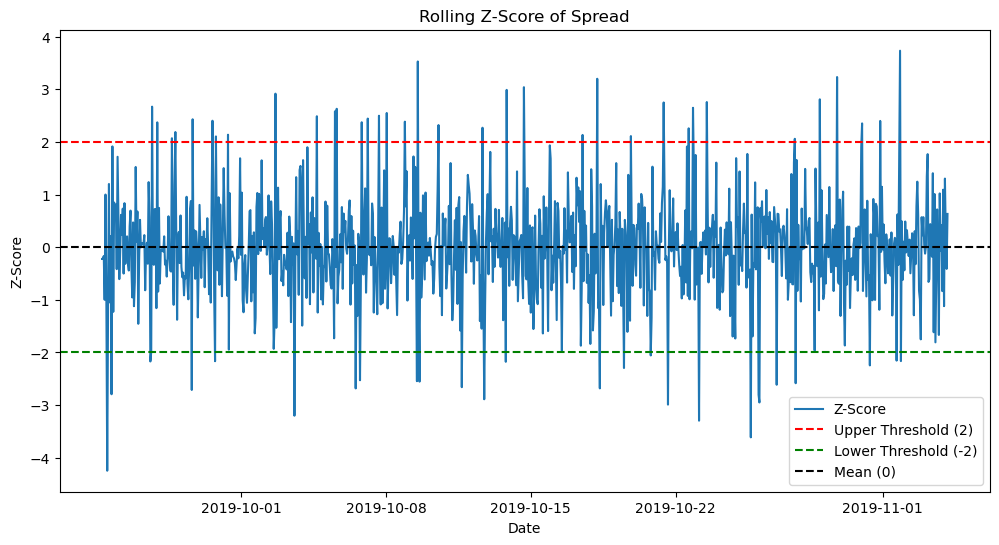

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Zscore'], label='Z-Score')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
plt.axhline(0, color='black', linestyle='--', label='Mean (0)')
plt.title('Rolling Z-Score of Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()


In [35]:

def backtest_trading(data, z_entry=2.0, z_exit=0.0):
    """
    Backtesting a simple pairs trading strategy based on Z-score signals.
    Entry Rules:
      - If Z-score > z_entry, then short ETH and long BTC.
      - If Z-score < -z_entry, then long ETH and short BTC.
    Exit Rule:
      - Close position when Z-score reverts to z_exit.
    Returns a list of individual trade PnLs and prints trade details.
    """
    position = 0  # +1: long ETH / short BTC; -1: short ETH / long BTC
    entry_idx = None
    trade_returns = []
    
    for i in range(len(data)):
        z = data['Zscore'].iloc[i]
        current_date = data.index[i]
        price_eth = data['Close_ETH'].iloc[i]
        price_btc = data['Close_BTC'].iloc[i]
        # For simplicity, we assume the hedge ratio is approximated by its current estimated value
        current_hr = hedge_ratio[i]
        
        # ENTRY CONDITIONS: only if we are flat (no open position)
        if position == 0:
            if z > z_entry:
                # Signal: Spread too high -> ETH is expensive relative to BTC.
                # Action: Short ETH, Long BTC.
                position = -1
                entry_idx = i
                entry_price_eth = price_eth
                entry_price_btc = price_btc
                print(f"{current_date}: Enter SHORT ETH, LONG BTC (Z = {z:.2f})")
            elif z < -z_entry:
                # Signal: Spread too low -> ETH is cheap relative to BTC.
                # Action: Long ETH, Short BTC.
                position = 1
                entry_idx = i
                entry_price_eth = price_eth
                entry_price_btc = price_btc
                print(f"{current_date}: Enter LONG ETH, SHORT BTC (Z = {z:.2f})")
        
        # EXIT CONDITION: if we are in a position and Z-score reverts to near zero
        elif position != 0:
            if (position == 1 and z >= z_exit) or (position == -1 and z <= z_exit):
                exit_price_eth = price_eth
                exit_price_btc = price_btc
                
                # Compute profit & loss (PnL) using a simple spread difference approach.
                # For a LONG ETH / SHORT BTC position, profit is (exit_eth - entry_eth) - current_hr*(exit_btc - entry_btc)
                # For a SHORT ETH / LONG BTC position, profit is the reverse.
                if position == 1:
                    pnl = (exit_price_eth - entry_price_eth) - current_hr * (exit_price_btc - entry_price_btc)
                    trade_type = "LONG ETH, SHORT BTC"
                else:  # position == -1
                    pnl = (entry_price_eth - exit_price_eth) - current_hr * (entry_price_btc - exit_price_btc)
                    trade_type = "SHORT ETH, LONG BTC"
                
                trade_returns.append(pnl)
                print(f"{current_date}: Exit position ({trade_type}) with PnL: {pnl:.2f}")
                position = 0  # reset position
                entry_idx = None

    total_profit = sum(trade_returns)
    print(f"\nTotal Profit from Backtesting: {total_profit:.2f}")
    return trade_returns

# Run backtesting simulation on our data
trade_returns = backtest_trading(data)


2019-09-24 13:00:00: Enter LONG ETH, SHORT BTC (Z = -4.25)
2019-09-24 15:00:00: Exit position (LONG ETH, SHORT BTC) with PnL: -0.56
2019-09-24 18:00:00: Enter LONG ETH, SHORT BTC (Z = -2.79)
2019-09-24 19:00:00: Exit position (LONG ETH, SHORT BTC) with PnL: 3.74
2019-09-26 15:00:00: Enter LONG ETH, SHORT BTC (Z = -2.17)
2019-09-26 17:00:00: Exit position (LONG ETH, SHORT BTC) with PnL: 1.34
2019-09-26 23:00:00: Enter SHORT ETH, LONG BTC (Z = 2.37)
2019-09-27 00:00:00: Exit position (SHORT ETH, LONG BTC) with PnL: 0.99
2019-09-27 16:00:00: Enter SHORT ETH, LONG BTC (Z = 2.07)
2019-09-27 17:00:00: Exit position (SHORT ETH, LONG BTC) with PnL: 0.15
2019-09-27 20:00:00: Enter SHORT ETH, LONG BTC (Z = 2.19)
2019-09-27 22:00:00: Exit position (SHORT ETH, LONG BTC) with PnL: 0.61
2019-09-28 15:00:00: Enter LONG ETH, SHORT BTC (Z = -2.71)
2019-09-28 16:00:00: Exit position (LONG ETH, SHORT BTC) with PnL: 2.69
2019-09-29 15:00:00: Enter SHORT ETH, LONG BTC (Z = 2.40)
2019-09-29 17:00:00: Exit p

In [36]:
def fetch_crypto_data(symbol, timeframe, since, limit=1000):

    exchange = ccxt.binanceus()

   
    since = exchange.parse8601(since)
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    return df[['Timestamp', 'Close']].set_index('Timestamp')


btc = fetch_crypto_data('DOT/USDT', '1h', '2019-08-01T00:00:00Z')
ltc = fetch_crypto_data('ADA/USDT', '1h', '2018-01-01T00:00:00Z')


data = pd.merge(btc, ltc, left_index=True, right_index=True, suffixes=('_DOT', '_ADA')).dropna()


In [37]:
print("DOT shape:", btc.shape, "ADA shape:", ltc.shape)
print("Merged shape:", data.shape)
print("Date range:", data.index.min(), "→", data.index.max())


DOT shape: (1000, 1) ADA shape: (1000, 1)
Merged shape: (0, 2)
Date range: NaT → NaT


In [38]:
exchange = ccxt.binanceus()
exchange.load_markets()
print("Supports DOT/USDT?", 'DOT/USDT' in exchange.symbols)
print("Supports ADA/USDT?", 'ADA/USDT' in exchange.symbols)


Supports DOT/USDT? True
Supports ADA/USDT? True


In [39]:
def fetch_all_data(symbol, timeframe, since_iso):
    exchange = ccxt.binanceus()
    since = exchange.parse8601(since_iso)
    all_ohlcv = []
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)
        if not ohlcv:
            break
        all_ohlcv += ohlcv
        # advance by one bar
        since = ohlcv[-1][0] + exchange.parse_timeframe(timeframe)*1000
    df = pd.DataFrame(all_ohlcv, columns=['ts','o','h','l','c','v'])
    df['ts'] = pd.to_datetime(df['ts'], unit='ms')
    return df.set_index('ts')['c'].rename(symbol)

# Fetch full history (or as much as the exchange provides)
series_dot = fetch_all_data('DOT/USDT','1h','2019-08-01T00:00:00Z')
series_ada = fetch_all_data('ADA/USDT','1h','2019-08-01T00:00:00Z')

# Then align on their intersection
common_idx = series_dot.index.intersection(series_ada.index)
data = pd.DataFrame({
    'Close_DOT': series_dot.loc[common_idx],
    'Close_ADA': series_ada.loc[common_idx],
})

print("Merged shape:", data.shape)
print("Date range:", data.index.min(), "→", data.index.max())


Merged shape: (30181, 2)
Date range: 2021-12-02 13:00:00 → 2025-05-13 08:00:00


In [40]:
def johansen_test(prices):

    result = coint_johansen(prices, det_order=0, k_ar_diff=1)
    trace_stat = result.lr1[0]
    crit_value = result.cvt[0, 1] 
    cointegrated = trace_stat > crit_value
    print("Johansen Test: Trace Statistic = {:.2f}, Critical Value (5%) = {:.2f}".format(trace_stat, crit_value))
    print("Result: {}".format("Cointegrated" if cointegrated else "Not Cointegrated"))
    return cointegrated
prices = data[['Close_DOT', 'Close_ADA']]
cointegrated = johansen_test(prices)

Johansen Test: Trace Statistic = 36.10, Critical Value (5%) = 15.49
Result: Cointegrated


In [41]:

def kalman_filter(y, x):

    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)  
    obs_mat = np.vstack([x, np.ones(len(x))]).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[0, 0],
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, _ = kf.filter(y.values)
    hedge_ratio = state_means[:, 0]
    intercept = state_means[:, 1]
    
    return hedge_ratio, intercept

hedge_ratio, intercept = kalman_filter(data['Close_DOT'], data['Close_ADA'])
data['Spread'] = data['Close_DOT'] - (hedge_ratio * data['Close_ADA'] + intercept)


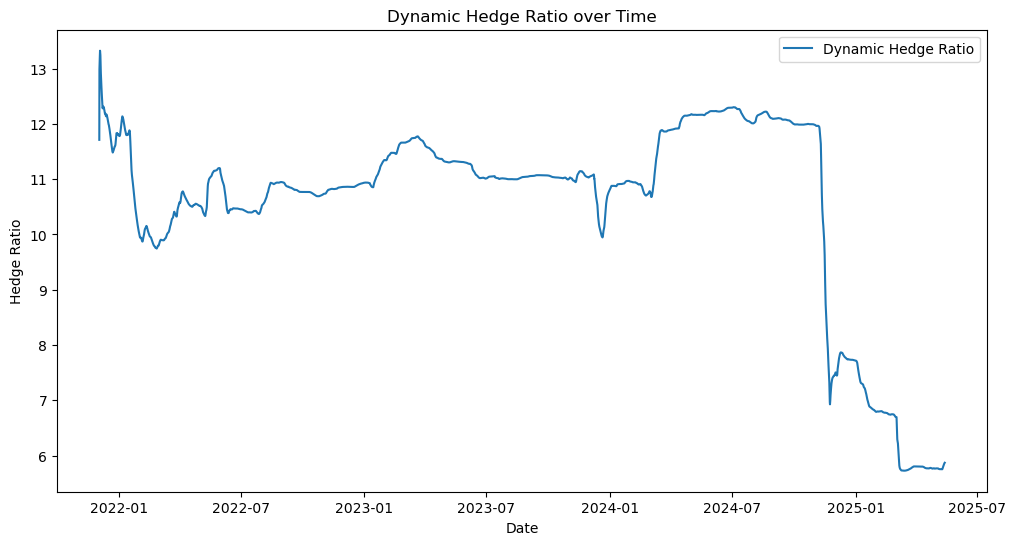

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, hedge_ratio, label='Dynamic Hedge Ratio')
plt.title('Dynamic Hedge Ratio over Time')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.show()


In [43]:
print(data.index.min(), data.index.max())
print(data.head(), data.tail())


2021-12-02 13:00:00 2025-05-13 08:00:00
                     Close_DOT  Close_ADA    Spread
ts                                                 
2021-12-02 13:00:00      35.92    1.69651  4.342798
2021-12-02 14:00:00      36.43    1.69750  2.575407
2021-12-02 15:00:00      36.02    1.69851  1.466025
2021-12-02 16:00:00      35.81    1.71268  0.812604
2021-12-02 17:00:00      35.98    1.72148  0.697815                      Close_DOT  Close_ADA    Spread
ts                                                 
2025-05-13 04:00:00      4.926     0.7908  0.168715
2025-05-13 05:00:00      4.920     0.7859  0.190668
2025-05-13 06:00:00      4.907     0.7914  0.144771
2025-05-13 07:00:00      4.977     0.7910  0.216201
2025-05-13 08:00:00      4.995     0.7931  0.220930


In [44]:
def calculate_zscore(spread, window=20):
    """
    Calculate the rolling Z-score for the spread.
    Z-score = (spread - rolling mean) / rolling standard deviation.
    """
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    zscore = (spread - rolling_mean) / rolling_std
    return zscore

# Calculate the Z-score for the spread
data['Zscore'] = calculate_zscore(data['Spread'])


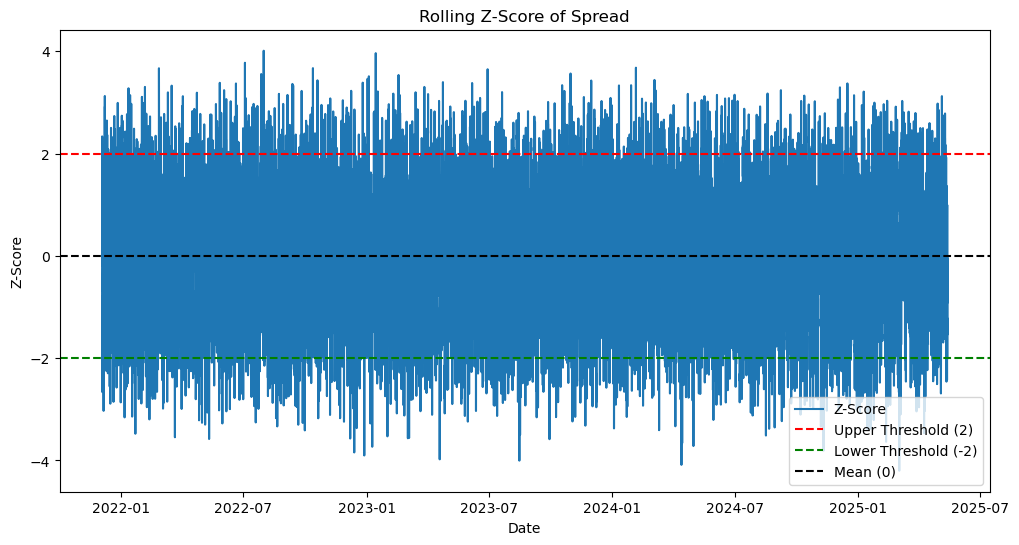

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Zscore'], label='Z-Score')
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold (2)')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold (-2)')
plt.axhline(0, color='black', linestyle='--', label='Mean (0)')
plt.title('Rolling Z-Score of Spread')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()


In [46]:

def backtest_trading(data, z_entry=2.0, z_exit=0.0):
    position = 0  
    entry_idx = None
    trade_returns = []
    
    for i in range(len(data)):
        z = data['Zscore'].iloc[i]
        current_date = data.index[i]
        price_LTC = data['Close_DOT'].iloc[i]
        price_btc = data['Close_ADA'].iloc[i]
        current_hr = hedge_ratio[i]
        
    
        if position == 0:
            if z > z_entry:
                position = -1
                entry_idx = i
                entry_price_LTC = price_LTC
                entry_price_btc = price_btc
                print(f"{current_date}: Enter SHORT DOT, LONG ADA (Z = {z:.2f})")
            elif z < -z_entry:
                position = 1
                entry_idx = i
                entry_price_LTC = price_LTC
                entry_price_btc = price_btc
                print(f"{current_date}: Enter LONG DOT, SHORT ADA (Z = {z:.2f})")
        
        elif position != 0:
            if (position == 1 and z >= z_exit) or (position == -1 and z <= z_exit):
                exit_price_LTC = price_LTC
                exit_price_btc = price_btc
            
                if position == 1:
                    pnl = (exit_price_LTC - entry_price_LTC) - current_hr * (exit_price_btc - entry_price_btc)
                    trade_type = "LONG DOT, SHORT ADA"
                else:  # position == -1
                    pnl = (entry_price_LTC - exit_price_LTC) - current_hr * (entry_price_btc - exit_price_btc)
                    trade_type = "SHORT DOT, LONG ADA"
                
                trade_returns.append(pnl)
                print(f"{current_date}: Exit position ({trade_type}) with PnL: {pnl:.2f}")
                position = 0  # reset position
                entry_idx = None

    total_profit = sum(trade_returns)
    print(f"\nTotal Profit from Backtesting: {total_profit:.2f}")
    return trade_returns

# Run backtesting simulation on our data
trade_returns = backtest_trading(data)


2021-12-03 11:00:00: Enter SHORT DOT, LONG ADA (Z = 2.34)
2021-12-03 15:00:00: Exit position (SHORT DOT, LONG ADA) with PnL: 0.63
2021-12-03 16:00:00: Enter LONG DOT, SHORT ADA (Z = -2.66)
2021-12-04 19:00:00: Exit position (LONG DOT, SHORT ADA) with PnL: -2.30
2021-12-05 15:00:00: Enter LONG DOT, SHORT ADA (Z = -3.03)
2021-12-05 16:00:00: Exit position (LONG DOT, SHORT ADA) with PnL: 0.86
2021-12-06 00:00:00: Enter LONG DOT, SHORT ADA (Z = -2.26)
2021-12-06 12:00:00: Exit position (LONG DOT, SHORT ADA) with PnL: 0.07
2021-12-07 07:00:00: Enter SHORT DOT, LONG ADA (Z = 2.07)
2021-12-08 03:00:00: Exit position (SHORT DOT, LONG ADA) with PnL: -1.29
2021-12-09 14:00:00: Enter LONG DOT, SHORT ADA (Z = -2.25)
2021-12-10 02:00:00: Exit position (LONG DOT, SHORT ADA) with PnL: 0.18
2021-12-10 12:00:00: Enter SHORT DOT, LONG ADA (Z = 2.65)
2021-12-10 14:00:00: Exit position (SHORT DOT, LONG ADA) with PnL: 0.86
2021-12-11 01:00:00: Enter SHORT DOT, LONG ADA (Z = 2.37)
2021-12-11 11:00:00: Exit 

In [48]:
def fetch_crypto_data(symbol, timeframe, since, limit=1000):
    
    #Fetching historical OHLCV data using the CCXT library. This returns a DataFrame with Timestamp as index and Close prices
    exchange = ccxt.binanceus()
    # Convert ISO formatted string to exchange timestamp
    since = exchange.parse8601(since)
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    return df[['Timestamp', 'Close']].set_index('Timestamp')

# Fetching daily data for BTC/USDT and ETH/USDT starting from Jan 1, 2017
btc = fetch_crypto_data('XRP/USDT', '1h', '2017-01-01T00:00:00Z')
eth = fetch_crypto_data('XLM/USDT', '1h', '2017-01-01T00:00:00Z')

# Merge the two datasets on the Timestamp index
data = pd.merge(btc, eth, left_index=True, right_index=True, suffixes=('_XRP', '_XLM')).dropna()


In [ ]:
def johansen_test(prices):
    
    #Performing Johansen cointegration test on the provided price DataFrame. this will return a boolean indicating whether the series are cointegrated.
    
    # det_order=0 implies no deterministic trend, k_ar_diff=1 sets lag differences.
    result = coint_johansen(prices, det_order=0, k_ar_diff=1)
    # We use the first trace statistic and its 5% critical value
    trace_stat = result.lr1[0]
    crit_value = result.cvt[0, 1]  # 5% significance level critical value
    cointegrated = trace_stat > crit_value
    print("Johansen Test: Trace Statistic = {:.2f}, Critical Value (5%) = {:.2f}".format(trace_stat, crit_value))
    print("Result: {}".format("Cointegrated" if cointegrated else "Not Cointegrated"))
    return cointegrated

# Running cointegration test on BTC and ETH closing prices
prices = data[['Close_BTC', 'Close_ETH']]
cointegrated = johansen_test(prices)